In [6]:

# LSTM model dummy
# Dummy model to predict the climate time series data

# !nvidia-smi

import tensorflow as tf 
# !pip install tensorflow-gpu
print(tf.__version__)

print('1: ', tf.config.list_physical_devices('GPU'))
print('2: ', tf.test.is_built_with_cuda)
print('3: ', tf.test.gpu_device_name())
print('4: ', tf.config.get_visible_devices())

2.6.2
1:  []
2:  <function is_built_with_cuda at 0x7f2b401c8d90>
3:  
4:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [7]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, RepeatVector, TimeDistributed
import math
from sklearn.metrics import mean_squared_error

## Data Processing

### Data Fetching and Cleaning

In [8]:


# create a dataset of 30 sequences from the provided Data
def creatDataset(x,y,time_step):
    Xs, Ys = [],[]
    for i in range(len(x)-time_step):
        v = x.iloc[i:i+time_step].values
        Xs.append(v)
        Ys.append(x.iloc[i+time_step])
    return np.array(Xs),np.array(Ys)
    

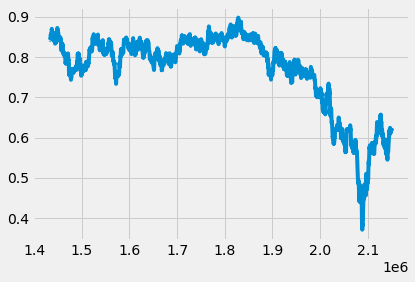

In [9]:
#getting data

scaler = MinMaxScaler()
df_normal = pd.read_csv('train_1.csv', delimiter=',')
df_normal_grp_ID1 = df_normal[df_normal['ID']=='id1'].dropna(axis=1, how='all')
df_normal_grp_ID1 = df_normal_grp_ID1.drop(df_normal_grp_ID1[['Label','ID']],axis =1)
# df_normal_grp_ID1 = df_normal_grp_ID1.iloc[0:(int(len(df_normal_grp_ID1)/5)),:]
df_normal_grp_ID1 = df_normal_grp_ID1.iloc[200000:300000,:]
df_normal_grp_ID1[['Time']] = scaler.fit_transform(df_normal_grp_ID1[['Time']])
# df_normal_grp_ID1
plt.plot(df_normal_grp_ID1['Signal1'])

In [10]:
df_normal_grp_ID1['Signal1']

1433404    0.842287
1433409    0.842287
1433419    0.842277
1433424    0.842257
1433432    0.842237
             ...   
2150060    0.621724
2150066    0.621894
2150074    0.622064
2150080    0.622244
2150089    0.622435
Name: Signal1, Length: 100000, dtype: float64

Text(0.5, 1.0, 'Plateau Attack (180000-190000) values')

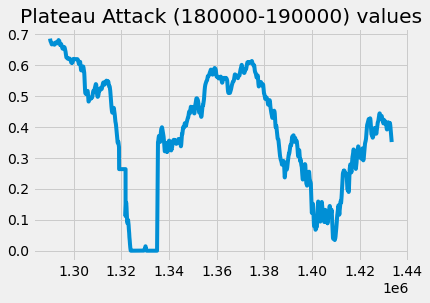

In [11]:
df_test_plat_ID1 = pd.read_csv('test_plateau.csv', delimiter=',')
df_test_plat_ID1 = df_test_plat_ID1[df_test_plat_ID1['ID']=='id1'].dropna(axis=1, how='all')
df_test_plat_ID1 = df_test_plat_ID1.drop(df_test_plat_ID1[['Label','ID']],axis =1)
# df_test_plat_ID1 = df_test_plat_ID1.iloc[0:(int(len(df_test_plat_ID1)/5)),:]
df_test_plat_ID1 = df_test_plat_ID1.iloc[180000:200000,:]
df_test_plat_ID1[['Time']] = scaler.fit_transform(df_test_plat_ID1[['Time']])

# df_test_plat_ID1.iloc[180000:250000,0:2]

# plt.plot(df_test_plat_ID1.iloc[180000:190000,1:2])
plt.plot(df_test_plat_ID1.iloc[:,1:2])
plt.title('Plateau Attack (180000-190000) values')

In [12]:
TIME_STEP = 30
X_train, Y_train = creatDataset(df_normal_grp_ID1[['Signal1']], df_normal_grp_ID1[['Signal1']], TIME_STEP)
X_test, Y_test = creatDataset(df_test_plat_ID1[['Signal1_of_ID']], df_test_plat_ID1[['Signal1_of_ID']], TIME_STEP)


In [13]:
Y_train.shape

# X_test.shape

(99970, 1)

### LSTM AUTOENCODER
#### Model Desgin

In [14]:


# n_features = X_train.shape[2]
model= Sequential()
model.add(LSTM(128, activation = 'relu', 
input_shape =(X_train.shape[1],X_train.shape[2]), return_sequences = True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(TIME_STEP))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 128)           66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 247,937
Trainable params: 247,937
Non-trainable params: 0
__________________________________________________

#### Model Fitting

In [15]:
# fit model
model.fit(X_train, Y_train, epochs=5, batch_size=30, validation_split=0.1, shuffle=False)
model.save("single_ID_LSTM_autoenc_old")

Epoch 1/5
3000/3000 [==============================] - 74s 24ms/step - loss: 0.0179 - val_loss: 0.0681
Epoch 2/5
3000/3000 [==============================] - 74s 25ms/step - loss: 0.0113 - val_loss: 0.0571
Epoch 3/5
3000/3000 [==============================] - 76s 25ms/step - loss: 0.0110 - val_loss: 0.0617
Epoch 4/5
3000/3000 [==============================] - 76s 25ms/step - loss: 0.0116 - val_loss: 0.0592
Epoch 5/5
3000/3000 [==============================] - 76s 25ms/step - loss: 0.0108 - val_loss: 0.0600
INFO:tensorflow:Assets written to: single_ID_LSTM_autoenc_old/assets


#### Training loss, finding Threshold

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


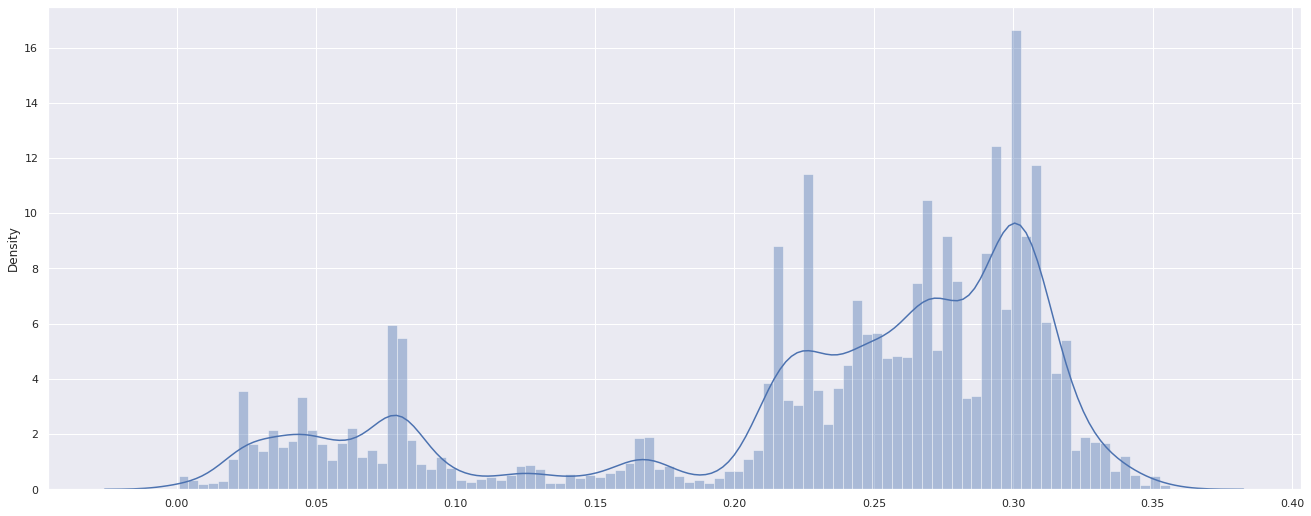

In [16]:
reconstructed_model = keras.models.load_model("single_ID_LSTM_autoenc_old")
x_train_predict = reconstructed_model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(x_train_predict - X_train), axis=1)
sns.set(rc={'figure.figsize':(20,8.27)})
sns.distplot(train_mae_loss,bins=100,kde=True)
plt.savefig('training_loss.png')


### Test Loss

(19970, 1)


/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

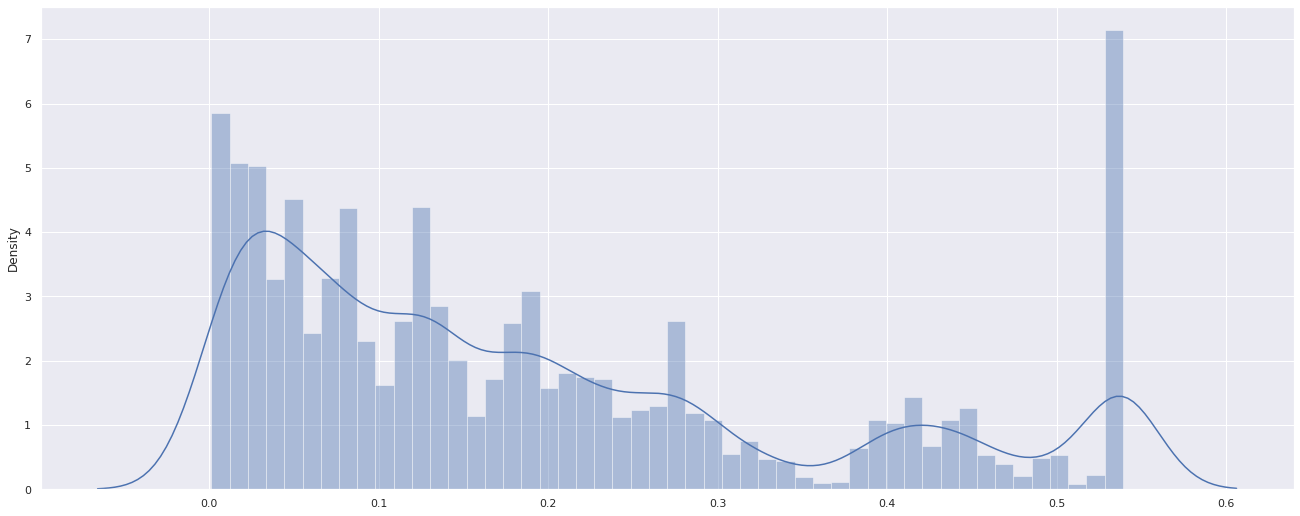

In [17]:
THRESHOLD = 0.45

x_test_predict = reconstructed_model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(x_test_predict - X_test), axis=1)
print(test_mae_loss.shape)

sns.distplot(test_mae_loss,bins=50,kde=True )

### Test Score Dataframe Creation and plotting


In [18]:
print(df_test_plat_ID1[TIME_STEP:].index.shape)
print(test_mae_loss.shape)

(19970,)
(19970, 1)


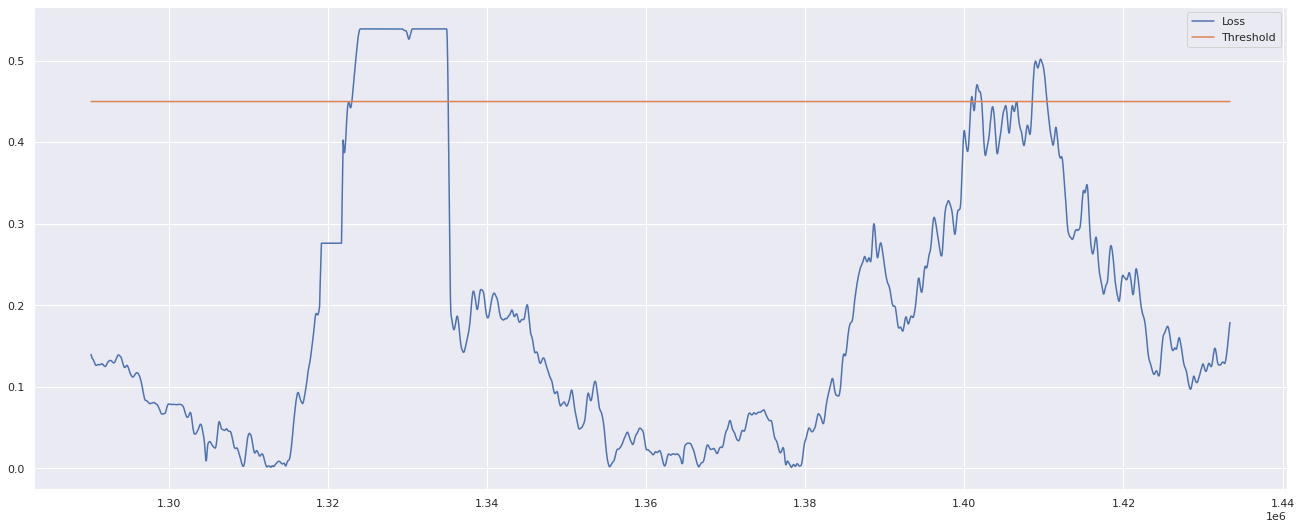

In [19]:
test_score_df = pd.DataFrame(index=df_test_plat_ID1[TIME_STEP:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Signal1'] = df_test_plat_ID1[TIME_STEP:].Signal1_of_ID

#plot the threshoold vs the actual loss values
plt.plot(test_score_df.index, test_score_df.loss, label='Loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='Threshold')
plt.legend()


# df['meantemp'].plot()
# df['humidity'].plot()
# plt.legend(['Sig1','Sig2'])

# train_set=df[:'2016'].iloc[:,0]
# test_set=df['2016':].iloc[:,0]
# df_normal_grp_ID1['Signal1_of_ID'].head()
# plt.plot(df_normal_grp_ID1['Time'],df_normal_grp_ID1['Signal1_of_ID'])
# df_normal_grp_ID1 = df_normal_grp_ID1.iloc[0:500,:]
# fig = 
# len(df_normal_grp_ID1)
# df_normal_grp_ID1['Signal1'].plot()

In [20]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,Signal1
1323044,0.450388,0.45,True,0.079187
1323050,0.450954,0.45,True,0.078146
1323057,0.451537,0.45,True,0.077095
1323065,0.452142,0.45,True,0.076034
1323072,0.452769,0.45,True,0.074963


In [21]:
df_test_plat_ID1.head

<bound method NDFrame.head of             Time  Signal1_of_ID  Signal2_of_ID
1290047  0.00000       0.685335           0.25
1290055  0.00005       0.685065           0.50
1290062  0.00010       0.684825           0.75
1290070  0.00015       0.684564           1.00
1290075  0.00020       0.684264           0.00
...          ...            ...            ...
1433351  0.99980       0.353744           0.25
1433359  0.99985       0.353083           0.50
1433364  0.99990       0.352412           0.75
1433374  0.99995       0.351762           1.00
1433379  1.00000       0.351151           0.00

[20000 rows x 3 columns]>

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


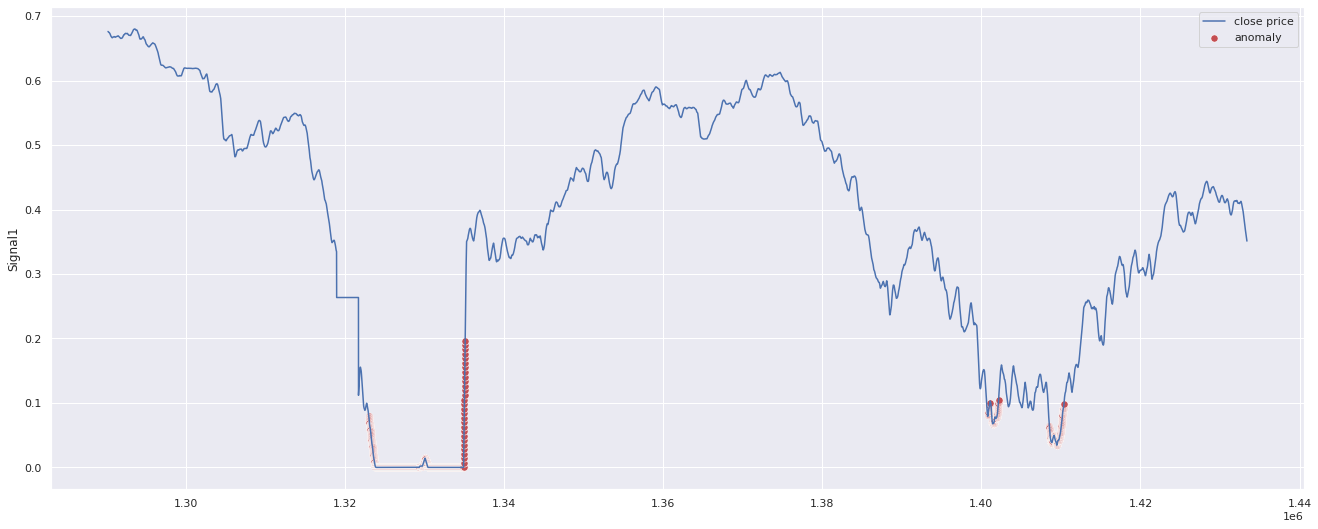

In [22]:
plt.plot(
  df_test_plat_ID1[TIME_STEP:].index, 
  df_test_plat_ID1[TIME_STEP:].Signal1_of_ID, 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  anomalies.Signal1,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.legend();